In [1]:
import tensorflow as tf
import random
import numpy as np
import glob
import os
import cv2
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [14]:
# load and preprocess dataset
#TensorFlow's Tensors are used instead of NumPy arrays for image processing
def read_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode image
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert image to float32
    image = (image / 255.0) - 0.5  # Normalize the image
    return image

In [34]:
def add_noise(image, noise_factor=0.2):
    noisy_image = image + noise_factor * tf.random.normal(shape=tf.shape(image), mean=0., stddev=1.)
    return tf.clip_by_value(noisy_image, clip_value_min=0., clip_value_max=1.)


In [ ]:
"""
#load and preprocess data from celebA with opencv 
DATA_PATH = "..\CelebA_denoising\celeba_hq\train_data"

#read image from folder
images_dataset = []
with os.scandir(DATA_PATH) as folder:
    for img in folder:
        img_array = cv2.imread(os.path.join(DATA_PATH,img)) 
        img_array = cv2.cvtColor( img_array, cv2.COLOR_BGR2RGB)
       # img_array = cv2.astype(np.float32) / 255.0 # Convert pixel values to floating point in [0, 1]
        img_resized = cv2.resize(img_array, (128, 128))  # Redimensionne l'image
        images_dataset.append(img_resized)

print(len(images_dataset))
"""

In [15]:
from skimage.metrics import structural_similarity as ssim

def calculate_average_msssim(original_data, encoded_data):
    msssim_values = []

    # Create iterators for the datasets
    original_iterator = iter(original_data)
    encoded_iterator = iter(encoded_data)

    # Iterate over the datasets
    for original_batch, encoded_batch in zip(original_iterator, encoded_iterator):

        # Iterate over the images in the batch
        for original, encoded in zip(original_batch, encoded_batch):
            original_np = original.numpy()  # Convert TensorFlow tensors to NumPy arrays
            encoded_np = encoded.numpy()

            # Ensure the images have the same shape
            assert original_np.shape == encoded_np.shape, "Original and encoded images must have the same dimensions."

            # Calculate SSIM
            msssim_value, _ = ssim(original_np, encoded_np, win_size=5, multichannel=True, full=True)
            msssim_values.append(msssim_value)

    # Calculate the average MS-SSIM
    average_msssim = np.mean(msssim_values)
    return average_msssim


In [41]:
def data_preparation(path, split_ratio = 0.8 ):
    # Load and shuffle the image paths
    image_paths = sorted(glob.glob(os.path.join(path, '*.jpg')))
    random.shuffle(image_paths)

     # Split the data into training and testing sets based on the train_percentage
    split_index = int(len(image_paths) * split_ratio)
    train_paths = image_paths[:split_index]
    test_paths = image_paths[split_index:]
    
    # Create TensorFlow Dataset for training and testing
    train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
    test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)

    # Map the preprocessing function to the datasets
    train_dataset = train_dataset.map(read_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(read_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    
    # Combine the normal images and the noisy images for training
    train_combined_dataset = tf.data.Dataset.zip((train_dataset, train_dataset.map(add_noise)))

    #Combine the normal images and the noisy images for testing
    test_combined_dataset = tf.data.Dataset.zip((test_dataset, test_dataset.map(add_noise)))
    
    #Divide the combined dataset into original and noisy images for training.
    train_dataset = train_combined_dataset.map(lambda x, y: (y, x))  # (original, noisy)

    # Dividir el conjunto de datos combinado para test
    test_dataset = test_combined_dataset.map(lambda x, y: (y, x))  # (original, noisy)
    
    # Batch and prefetch the datasets
    train_dataset = train_dataset.batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return train_dataset, test_dataset


In [44]:
# Define the path to your dataset directory
DATA_PATH =  r'C:\Users\ilhem\OneDrive - Haute Ecole de Namur-Liege-Luxembourg\Bureau\CelebA_denoising\celeba_hq\val'
train_dataset, test_dataset = data_preparation(DATA_PATH, split_ratio = 0.8 )
print(type(train_dataset))
print(type(test_dataset))
print(len(train_dataset))
print(len(test_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
9
3


In [33]:
#Function to visualize batches of images
def visualize_batches(original_images, noisy_images, num_images_to_show=3):
    """
    Visualizes original and noisy images from a batch.
    
    Parameters:
    - original_images: NumPy array of original images
    - noisy_images: NumPy array of noisy images
    - num_images_to_show: Number of images to display
    """
    plt.figure(figsize=(3 * num_images_to_show, 4))
    
    for i in range(num_images_to_show):
        # Image originale
        plt.subplot(2, num_images_to_show, i + 1)
        plt.imshow(np.clip(original_images[i], 0, 1))
        plt.title("Noisy")
        plt.axis('off')

        # Image with noise
        plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
        plt.imshow(np.clip(noisy_images[i], 0, 1))
        plt.title("Original")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Extract a batch of original and noisy images from the train_batch_generator
#original_batch, noisy_batch = next(train_batch_generator)

# Visualize the images
visualize_batches(original_batch, noisy_batch, num_images_to_show=3)

In [25]:
#Experiment 1
# Define input shape and latent dimension

input_shape = (128, 128, 3)
latent_dim = 64

# Encoder
encoder_inputs = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D(2, padding='same')(x)

# Decoder
x = layers.Conv2D(128, 3, activation='relu', padding='same')(encoded)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
decoded = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder1 = tf.keras.Model(encoder_inputs, decoded)


In [28]:
# Compile the Autoencoder model
autoencoder1.compile(optimizer='adam', loss='binary_crossentropy')
#plot_model(autoencoder1, to_file='autoencoder.png', show_shapes=True, show_layer_names=True)

In [29]:
autoencoder1.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 128)     

In [30]:
# train the model
history1 = autoencoder1.fit(train_dataset, epochs= 10, validation_data=test_dataset)

Epoch 1/10


ValueError: in user code:

    C:\Users\ilhem\anaconda3\envs\Denoising_Autoencoder\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\ilhem\anaconda3\envs\Denoising_Autoencoder\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ilhem\anaconda3\envs\Denoising_Autoencoder\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ilhem\anaconda3\envs\Denoising_Autoencoder\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ilhem\anaconda3\envs\Denoising_Autoencoder\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ilhem\anaconda3\envs\Denoising_Autoencoder\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\ilhem\anaconda3\envs\Denoising_Autoencoder\lib\site-packages\tensorflow\python\keras\engine\training.py:756 train_step
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    C:\Users\ilhem\anaconda3\envs\Denoising_Autoencoder\lib\site-packages\tensorflow\python\keras\engine\training.py:2736 _minimize
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
    C:\Users\ilhem\anaconda3\envs\Denoising_Autoencoder\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    C:\Users\ilhem\anaconda3\envs\Denoising_Autoencoder\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:1270 _filter_grads
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['conv2d_42/kernel:0', 'conv2d_42/bias:0', 'conv2d_43/kernel:0', 'conv2d_43/bias:0', 'conv2d_44/kernel:0', 'conv2d_44/bias:0', 'conv2d_45/kernel:0', 'conv2d_45/bias:0', 'conv2d_46/kernel:0', 'conv2d_46/bias:0', 'conv2d_47/kernel:0', 'conv2d_47/bias:0', 'conv2d_48/kernel:0', 'conv2d_48/bias:0'].


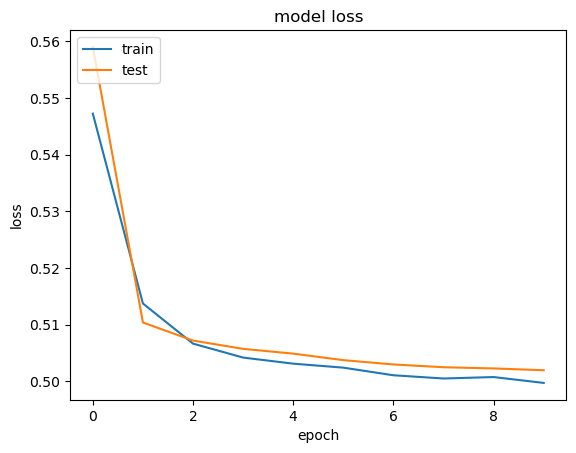

In [51]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

128
68


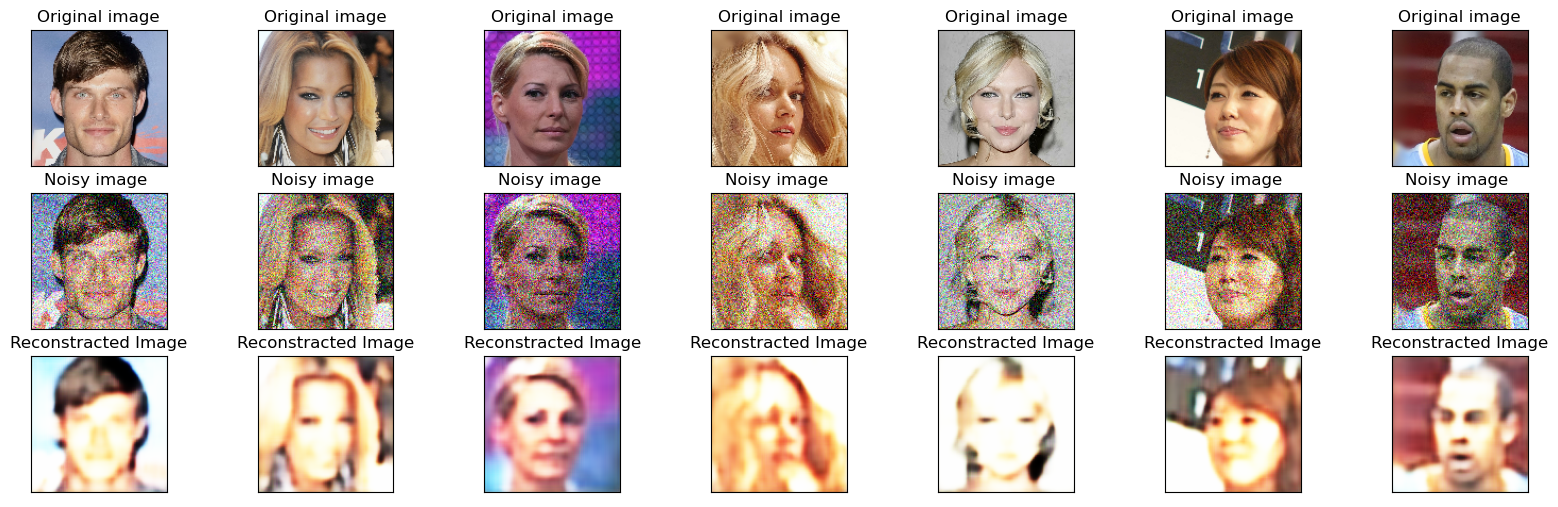

In [52]:
def visualize_encoded_images(test_dataset, autoencoder_model):
    # Get some test data samples
    sample_originals, sample_noisy = next(iter(test_dataset))

    # Get model predictions for noisy images
    decoded_images = autoencoder_model.predict(sample_noisy)

    # Display a subset of samples for visualization
    n = 7  # Number of samples to plot
    plt.figure(figsize=(20, 6))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(sample_noisy[i])
        plt.title("Original Image")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(sample_originals[i])
        plt.title("Noisy Image")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(decoded_images[i])
        plt.title("Reconstructed Image")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()
visualize_encoded_images(test_dataset, autoencoder1)  

In [62]:
def dataset_to_numpy(dataset):
    # Initialize an empty list to store the elements
    elements = []

    # Iterate over the dataset and accumulate elements
    for element in dataset:
        elements.append(element.numpy())

    # Convert the list of elements to a NumPy array
    np_array = np.array(elements)

    return np_array

# Example usage:
decoded_images1 = tf.data.Dataset.from_tensor_slices(np.random.rand(10, 128, 128, 3).astype(np.float32))
sample_originals1 = tf.data.Dataset.from_tensor_slices(np.random.rand(10, 128, 128, 3).astype(np.float32))

# Convert the TensorFlow dataset to NumPy array
decoded_data1 = dataset_to_numpy(decoded_images1)
original_data1 = dataset_to_numpy(sample_originals1)

average_msssim1 = calculate_average_msssim(original_data1, decoded_data1)
print(f'Average MS-SSIM: {average_msssim1}')


Average MS-SSIM: 0.02383850639899246


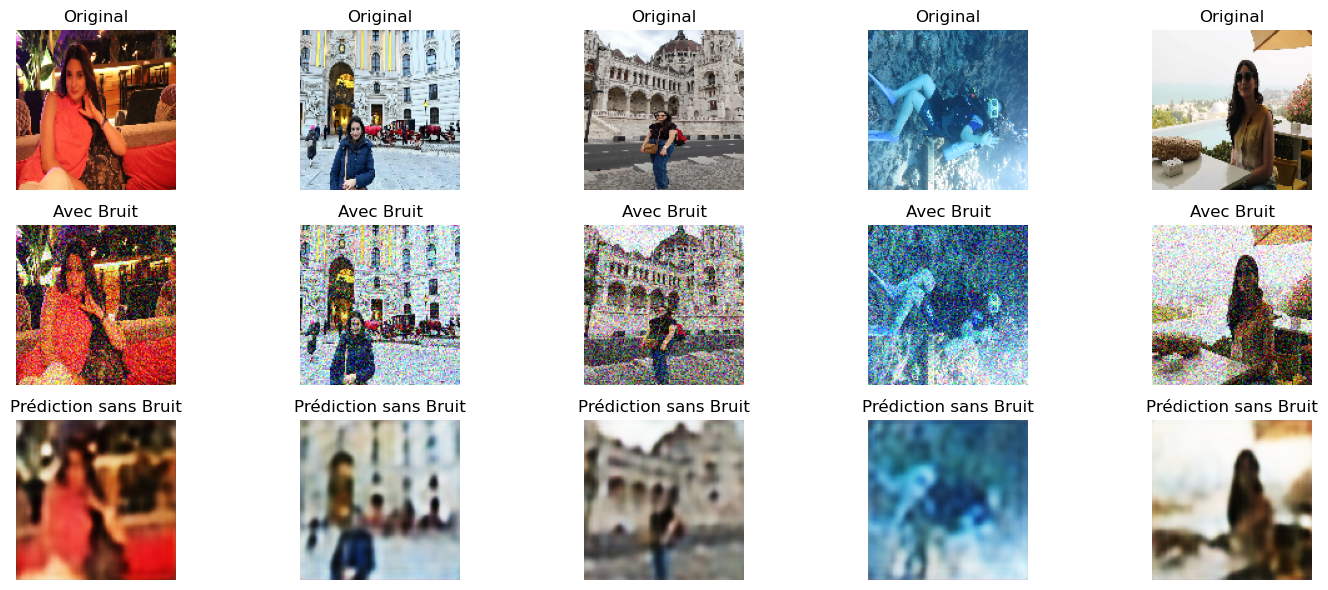

In [47]:
# Define the path to the real images
AMANIPATH = "..\CelebA_denoising\Amani"
amani_test = read_and_preprocess_image(AMANIPATH)
visualize_encoded_images(amani_test, autoencoder1)  

In [48]:
# Example usage:
decoded_amani = tf.data.Dataset.from_tensor_slices(np.random.rand(10, 128, 128, 3).astype(np.float32))
original_amani = tf.data.Dataset.from_tensor_slices(np.random.rand(10, 128, 128, 3).astype(np.float32))

# Convert the TensorFlow dataset to NumPy array
decoded_data = dataset_to_numpy(decoded_amani)
original_data = dataset_to_numpy(original_amani)

# Print the shape of the NumPy array
print(f'Shape of NumPy array: {numpy_array.shape}')
print(type(decoded_data))
print(type(original_data))

average_msssim = calculate_average_msssim(original_data, decoded_data)
print(f'Average MS-SSIM: {average_msssim}')

Shape of NumPy array: (10, 128, 128, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Average MS-SSIM: 0.022646007213263368


In [55]:
#deeper autoencoder 
# Define the latent dimension
input_shape = (128, 128, 3)
latent_dim = 128

# Encoder
encoder_inputs = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D(2, padding='same')(x)

# Decoder
x = layers.Conv2D(256, 3, activation='relu', padding='same')(encoded)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
decoded = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

# Create the model
autoencoder2 = tf.keras.Model(encoder_inputs, decoded)
# Compile the model
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history2 = autoencoder2.fit(train_dataset, epochs= 20, validation_data=test_dataset)

Epoch 1/20
68/68 [==============================] - 277s 4s/step - loss: 0.5911 - val_loss: 0.5391
Epoch 2/20
68/68 [==============================] - 275s 4s/step - loss: 0.5288 - val_loss: 0.5223
Epoch 3/20
68/68 [==============================] - 279s 4s/step - loss: 0.5185 - val_loss: 0.5167
Epoch 4/20
68/68 [==============================] - 279s 4s/step - loss: 0.5144 - val_loss: 0.5141
Epoch 5/20
68/68 [==============================] - 274s 4s/step - loss: 0.5133 - val_loss: 0.5125
Epoch 6/20
68/68 [==============================] - 276s 4s/step - loss: 0.5100 - val_loss: 0.5111
Epoch 7/20
68/68 [==============================] - 271s 4s/step - loss: 0.5108 - val_loss: 0.5107
Epoch 8/20
68/68 [==============================] - 281s 4s/step - loss: 0.5081 - val_loss: 0.5096
Epoch 9/20
68/68 [==============================] - 272s 4s/step - loss: 0.5073 - val_loss: 0.5099
Epoch 10/20
68/68 [==============================] - 270s 4s/step - loss: 0.5066 - val_loss: 0.5083
Epoch 11/

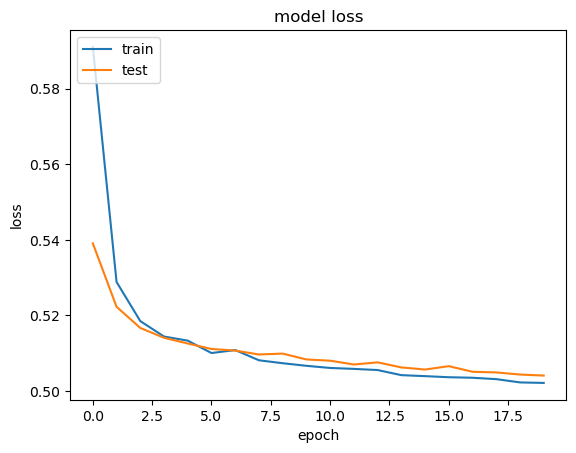

In [56]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

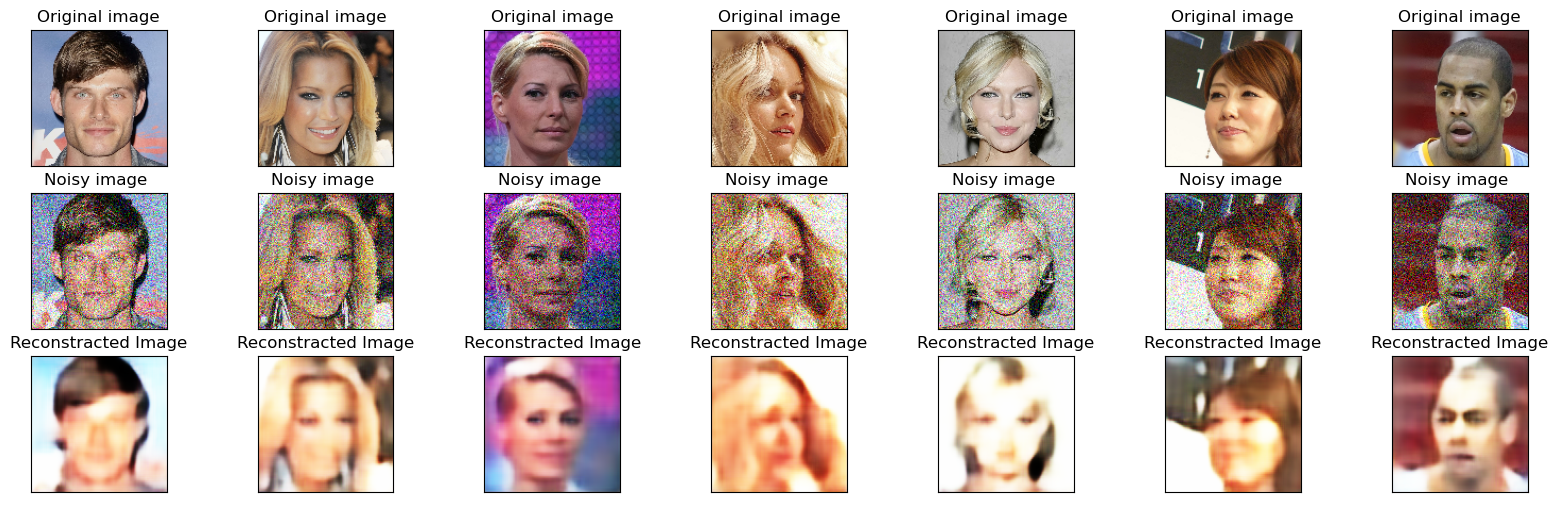

In [58]:
# Get some samples from the test dataset
visualize_encoded_images(test_dataset, autoencoder2)  


In [ ]:
# Example usage:
decoded_images2 = tf.data.Dataset.from_tensor_slices(np.random.rand(10, 128, 128, 3).astype(np.float32))
sample_originals2 = tf.data.Dataset.from_tensor_slices(np.random.rand(10, 128, 128, 3).astype(np.float32))

# Convert the TensorFlow dataset to NumPy array
decoded_data2 = dataset_to_numpy(decoded_images2)
original_data2 = dataset_to_numpy(sample_originals2)

average_msssim2 = calculate_average_msssim(original_data2, decoded_data2)
print(f'Average MS-SSIM: {average_msssim2}')

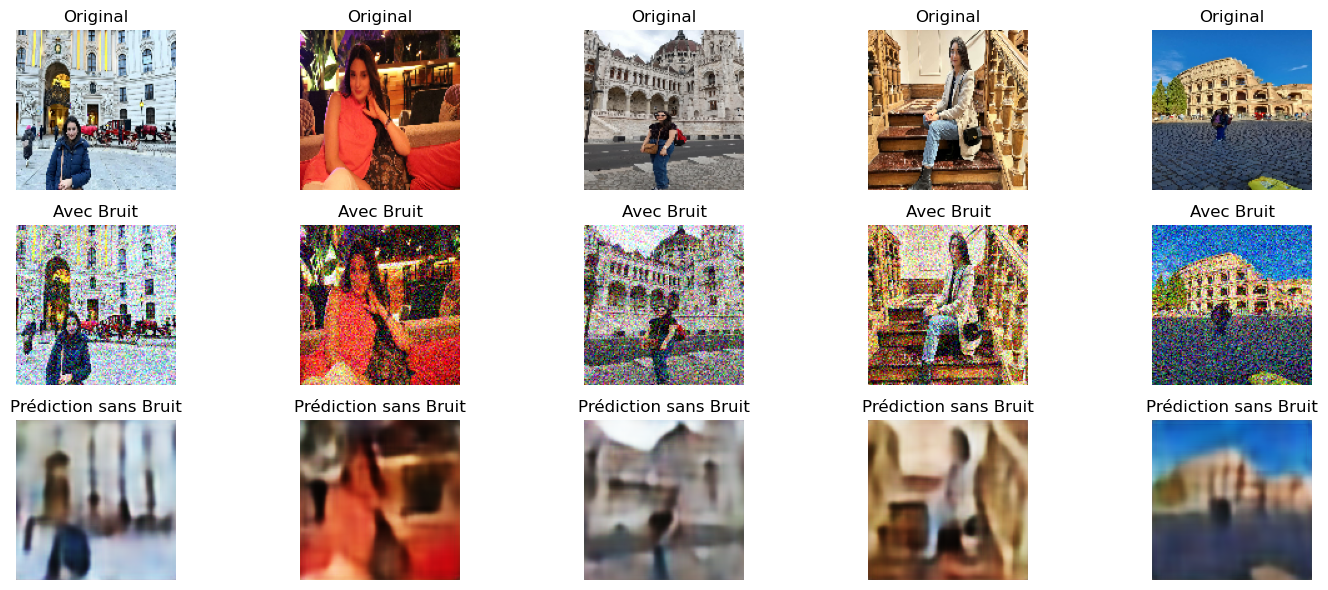

In [59]:
visualize_encoded_images(amani_test, autoencoder2)  

In [60]:
# deeper autoencoder version 2

input_shape = (128, 128, 3)
latent_dim = 64
# Encoder
encoder_inputs = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)  # Nouvelle couche
encoded = layers.MaxPooling2D(2, padding='same')(x)

# Decoder
x = layers.Conv2D(512, 3, activation='relu', padding='same')(encoded)  # Correspond à la dernière couche du codificateur
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
decoded = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

# Create the model
autoencoder3 = tf.keras.Model(encoder_inputs, decoded)

# Compile the model
autoencoder3.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder3.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 128)     

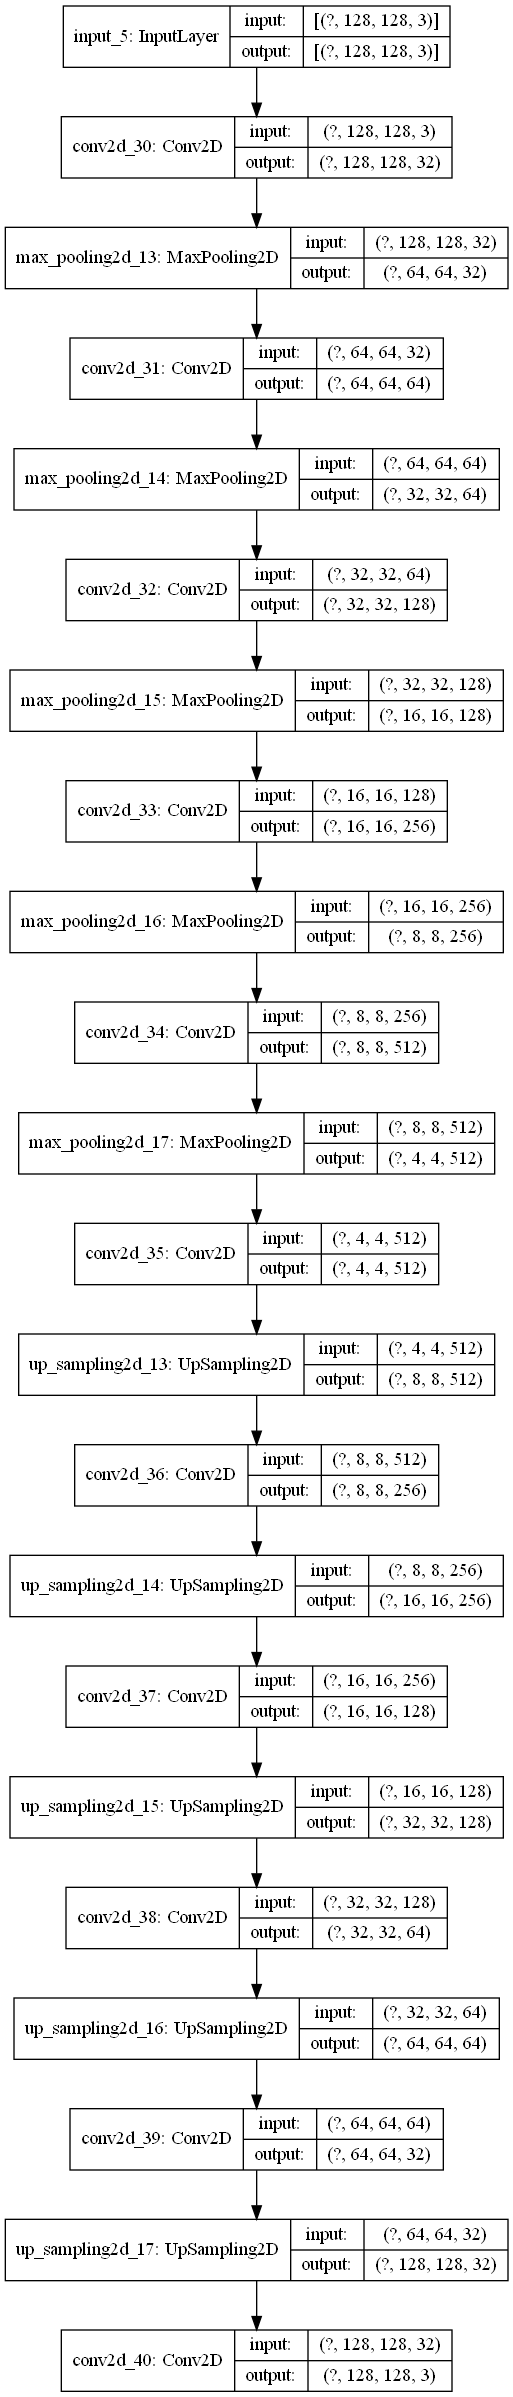

In [61]:
from IPython.display import Image
plot_model(autoencoder3, to_file='autoencoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train the model
history3 = autoencoder3.fit(train_dataset, epochs= 17, validation_data=test_dataset)

Epoch 1/17
68/68 [==============================] - 319s 5s/step - loss: 0.6729 - val_loss: 0.6525
Epoch 2/17
68/68 [==============================] - 313s 5s/step - loss: 0.5768 - val_loss: 0.5489
Epoch 3/17
68/68 [==============================] - 4614s 68s/step - loss: 0.5401 - val_loss: 0.5352
Epoch 4/17
68/68 [==============================] - 325s 5s/step - loss: 0.5321 - val_loss: 0.5331
Epoch 5/17
68/68 [==============================] - 312s 5s/step - loss: 0.5268 - val_loss: 0.5249
Epoch 6/17
49/68 [====================>.........] - ETA: 1:21 - loss: 0.5224

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
visualize_encoded_images(test_dataset, autoencoder3)  

In [ ]:
# Example usage:
decoded_images3 = tf.data.Dataset.from_tensor_slices(np.random.rand(10, 128, 128, 3).astype(np.float32))
sample_originals3 = tf.data.Dataset.from_tensor_slices(np.random.rand(10, 128, 128, 3).astype(np.float32))

# Convert the TensorFlow dataset to NumPy array
decoded_data3 = dataset_to_numpy(decoded_images3)
original_data3 = dataset_to_numpy(sample_originals3)

average_msssim3 = calculate_average_msssim(original_data3, decoded_data3)
print(f'Average MS-SSIM: {average_msssim3}')

In [ ]:
visualize_encoded_images(amani_test, autoencoder3)  

In [ ]:
# Extract latent vectors
#train_dataset = train_images  # Make sure train_images is a tensor or numpy array containing your training images
latent_vectors = encoder.predict(train_dataset)

# Reduce dimensionality with TSNE
latent_2d = TSNE(n_components=2).fit_transform(latent_vectors.reshape(latent_vectors.shape[0], -1))
#print(latent_vectors)
y_train = latent_vectors[1,:]  # Assuming this is for labels, replace it with your actual labels
# Visualize the latent space
plt.figure(figsize=(10, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], cmap='viridis')  # Replace y_train with your actual labels
plt.colorbar()
plt.title('t-SNE Projection of Latent Vectors')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()